## Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import shap
import matplotlib.pyplot as plt

import xgboost as xgb

In [14]:
import xgboost as xgb
print(xgb.__version__)


3.0.2


## Load the dataset

In [63]:
df_x = pd.read_csv("x_train.csv") # features
df_y = pd.read_csv("y_train.csv") # label

# Example placeholder:
X_train = df_x
y_train = df_y["label"]

In [65]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)

X shape: (228312, 20)
y shape: (228312,)


In [42]:
X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,-0.866025,-0.857659,0.19679,0.549192,-0.891963,-0.205778,-0.322394,-1.761955,-1.317665,-2.074913,-0.243980,-0.303202,-0.478848,-0.429761,-0.487085,-0.449686,1.127844,-0.337809,-0.05047,0.939838
1,1.154701,1.165964,0.19679,1.305940,1.121123,-0.205778,-0.322394,0.567551,0.758918,0.481948,-0.243980,-0.303202,0.457120,0.918137,-0.487085,-0.449686,1.127844,-0.010400,-0.05047,0.457143
2,-0.866025,-0.857659,0.19679,0.397842,1.121123,-0.205778,-0.322394,-1.761955,-1.317665,0.481948,-0.243980,-0.303202,1.393089,-0.429761,2.954213,2.223772,1.127844,-0.337809,-1.06401,-0.508247
3,-0.866025,-0.857659,0.19679,-0.358906,-0.891963,-0.205778,-0.322394,0.567551,0.758918,0.481948,4.098699,-0.303202,0.457120,-0.429761,-0.487085,-0.449686,-0.886647,0.644420,-0.05047,0.939838
4,-0.866025,-0.857659,0.19679,-0.207556,1.121123,-0.205778,-0.322394,0.567551,-1.317665,0.481948,-0.243980,-0.303202,0.457120,3.613931,-0.257665,-0.449686,-0.886647,-0.337809,-0.05047,0.939838


In [43]:
y_train.head()

0    0.0
1    2.0
2    0.0
3    0.0
4    0.0
Name: label, dtype: float64

### XGBoost parameters

In [45]:
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",   # avoids warning
    tree_method="hist",      # fast, good default
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

if "use_label_encoder" in xgb_clf.get_params():
    xgb_clf.set_params(use_label_encoder=None)


param_grid = {
    "n_estimators": [100, 200], # number of boosting rounds
    "max_depth": [3, 5, 7], # depth of the tree
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0], # fraction of samples per tree
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [1, 5, 10], # L2 regularization
}

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc_ovr",  # use AUC-ROC for 1 vs. rest
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [46]:
# Grid-search CV
grid_search.fit(X_train, y_train)

# Best parameters selection
print("\nBest parameters found:")
print(grid_search.best_params_)

print(f"\nBest CV AUC-ROC: {grid_search.best_score_:.4f}")

# Select the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=

### Test set evaluation

In [47]:
df_x_test = pd.read_csv("x_test.csv") # features
df_y_test = pd.read_csv("y_test.csv") # label

X_test = df_x_test
y_test = df_y_test["label"]

In [48]:
# predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)   # shape = (n_samples, 3)

# ===== MULTI-CLASS METRICS =====
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

# ROC-AUC for multi-class (One-vs-Rest)
auc_roc = roc_auc_score(y_test, y_proba, multi_class="ovr")

print("\n=== Test Set Performance ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro)   : {recall:.4f}")
print(f"F1-score (macro) : {f1:.4f}")
print(f"AUC-ROC (OvR)    : {auc_roc:.4f}")



=== Test Set Performance ===
Accuracy : 0.8504
Precision (macro): 0.4710
Recall (macro)   : 0.3917
F1-score (macro) : 0.4034
AUC-ROC (OvR)    : 0.7850


### SHAP analysis (XGBoost)

X_test shape: (25368, 20)
Number of features: 20
Converted to list format: 3 classes
Number of classes: 3
SHAP values shape per class: (25368, 20)
Base values: [1.9463633, -1.7931936, 0.018936843]


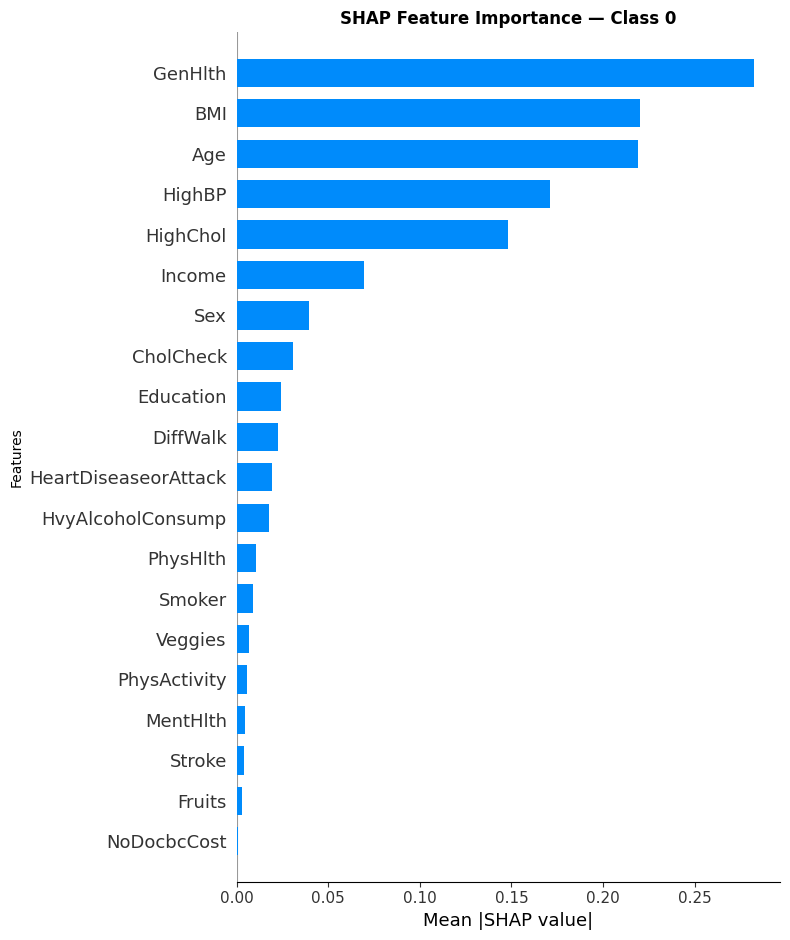

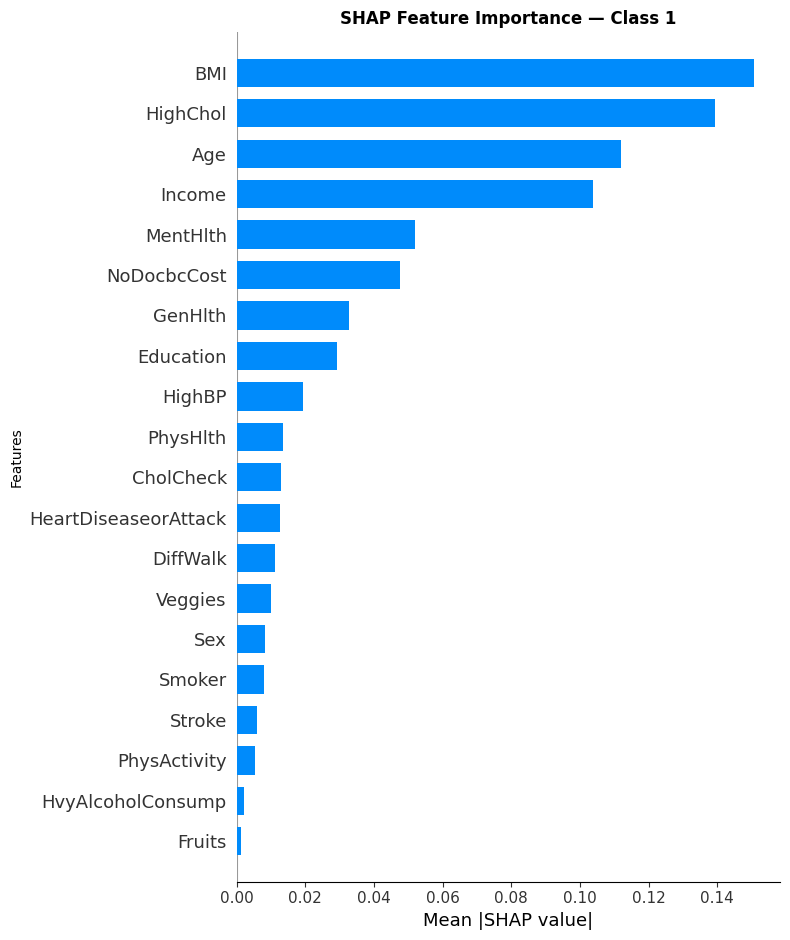

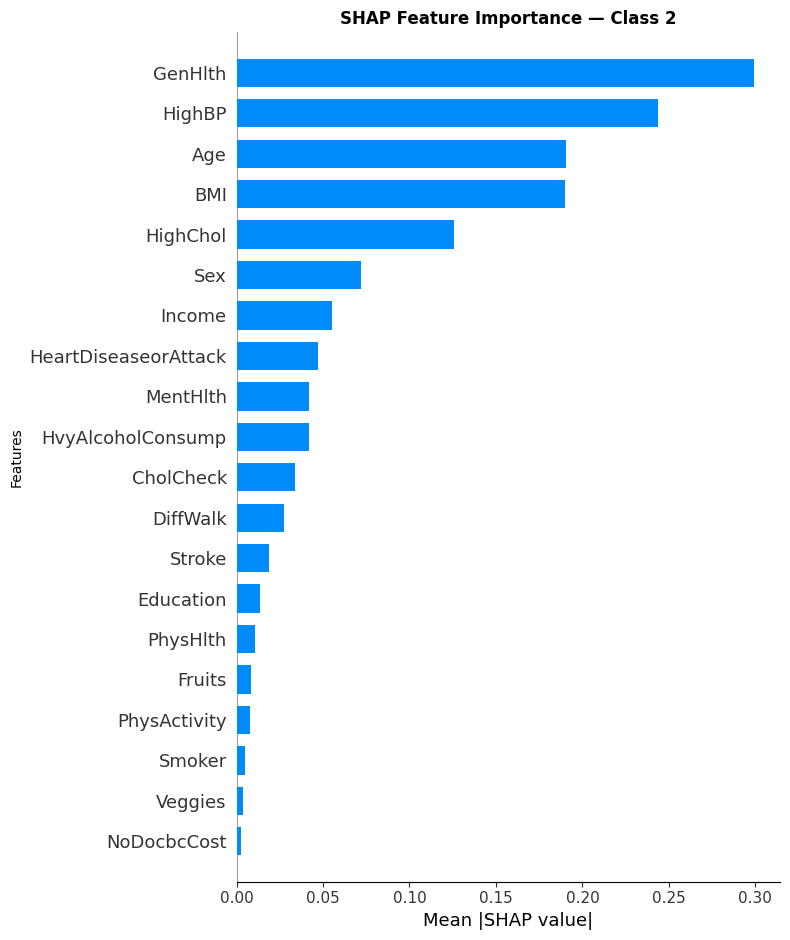

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/var/folders/vl/mrm_cfx13hzfrlxqk813nx6r0000gn/T/ipykernel_36314/3779243823.py:77: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


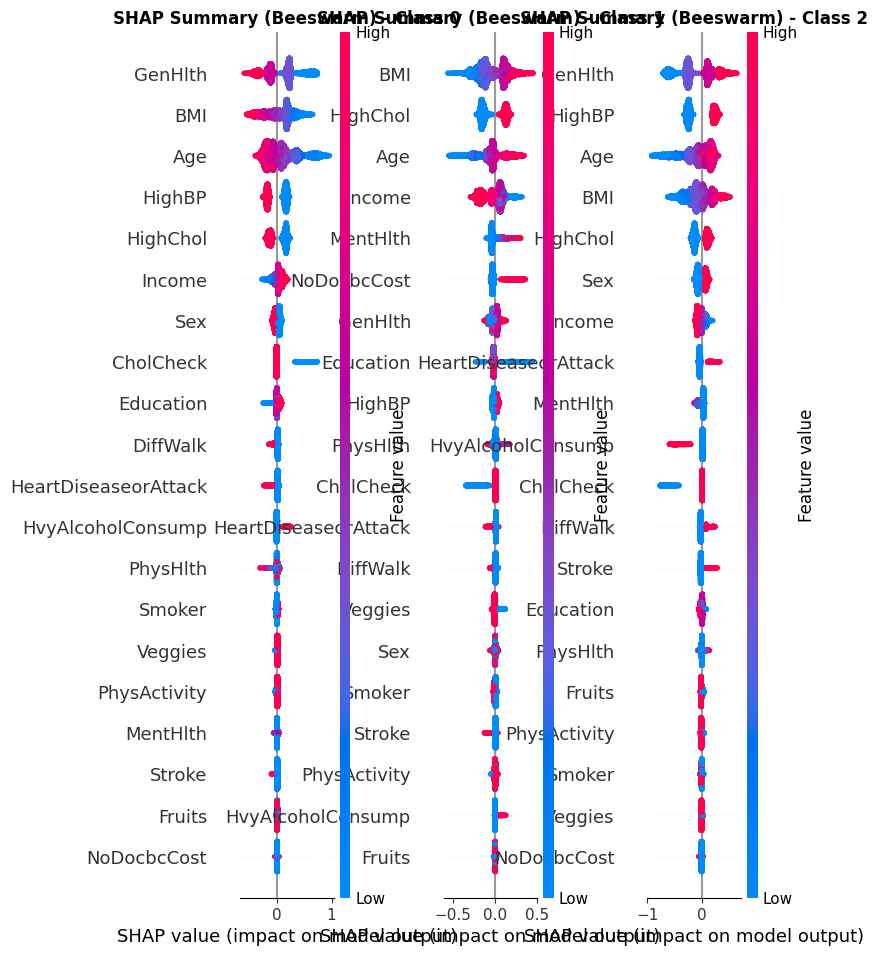


Class: Class 0
             Feature  Mean |SHAP|
             GenHlth     0.282440
                 BMI     0.220304
                 Age     0.219328
              HighBP     0.170946
            HighChol     0.148149
              Income     0.069584
                 Sex     0.039543
           CholCheck     0.030708
           Education     0.024321
            DiffWalk     0.022738
HeartDiseaseorAttack     0.019514
   HvyAlcoholConsump     0.017680
            PhysHlth     0.010372
              Smoker     0.009228
             Veggies     0.006989
        PhysActivity     0.005675
            MentHlth     0.004516
              Stroke     0.004148
              Fruits     0.002722
         NoDocbcCost     0.000988

Class: Class 1
             Feature  Mean |SHAP|
                 BMI     0.150709
            HighChol     0.139300
                 Age     0.111912
              Income     0.103704
            MentHlth     0.052078
         NoDocbcCost     0.047472
             Gen

In [60]:
# Fit your model (assuming you've already done grid_search.fit())
best_model = grid_search.best_estimator_

X_test_values = X_test.values

print(f"X_test shape: {X_test_values.shape}")
print(f"Number of features: {X_test_values.shape[1]}")

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_values)
base_value = explainer.expected_value

# Handle both old and new SHAP versions
# New versions return shape (n_samples, n_features, n_classes)
# Old versions return list of (n_samples, n_features) arrays
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # New SHAP format: transpose to get (n_classes, n_samples, n_features)
    shap_values = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
    print(f"Converted to list format: {len(shap_values)} classes")

print(f"Number of classes: {len(shap_values)}")
print(f"SHAP values shape per class: {shap_values[0].shape}")
print(f"Base values: {base_value}")

class_names = ["Class 0", "Class 1", "Class 2"]  # Adjust to your class names

# ============================================================================
# 1. Summary plots (feature importance bars) for each class
# ============================================================================

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# for i in range(len(shap_values)):
#     plt.sca(axes[i])
#     shap.summary_plot(shap_values[i], X_test_values, plot_type="bar", show=False, 
#                       feature_names=X_test.columns.tolist())
#     axes[i].set_title(f"Feature Importance - {class_names[i]}", fontsize=12, fontweight='bold')
#     axes[i].set_xlabel("Mean |SHAP value|")

# plt.tight_layout()
# plt.show()

for i in range(len(shap_values)):
    plt.figure(figsize=(6, 5))
    plt.sca(plt.gca())   # activate this figure's axis

    shap.summary_plot(
        shap_values[i],
        X_test_values,
        plot_type="bar",
        feature_names=X_test.columns.tolist(),
        show=False
    )

    plt.title(f"SHAP Feature Importance — {class_names[i]}", fontsize=12, fontweight='bold')
    plt.xlabel("Mean |SHAP value|")
    plt.ylabel("Features")

    plt.tight_layout()
    plt.show()



# ============================================================================
# 2. Detailed summary plots (beeswarm) for each class
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(len(shap_values)):
    plt.sca(axes[i])
    shap.summary_plot(shap_values[i], X_test_values, show=False, 
                      feature_names=X_test.columns.tolist())
    axes[i].set_title(f"SHAP Summary (Beeswarm) - {class_names[i]}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# ============================================================================
# 5. Waterfall plot for a single prediction
# ============================================================================

# for class_idx in range(len(shap_values)):
#     sample_idx = 0
#     explanation = shap.Explanation(
#         values=shap_values[class_idx][sample_idx],
#         base_values=base_value[class_idx],
#         data=X_test_values[sample_idx],
#         feature_names=X_test.columns.tolist()
#     )
    
#     plt.figure(figsize=(10, 6))
#     shap.waterfall_plot(explanation, show=False)
#     plt.title(f"Waterfall Plot - Sample {sample_idx}, {class_names[class_idx]}")
#     plt.tight_layout()
#     plt.show()

# # ============================================================================
# # 6. Compare classes: feature importance heatmap
# # ============================================================================

# fig, ax = plt.subplots(figsize=(12, 6))

# # Calculate mean absolute SHAP for each feature and class
# feature_importance = np.array([
#     np.abs(shap_values[i]).mean(axis=0)
#     for i in range(len(shap_values))
# ])

# im = ax.imshow(feature_importance, aspect='auto', cmap='viridis')
# ax.set_yticks(range(len(class_names)))
# ax.set_yticklabels(class_names)
# ax.set_xticks(range(X_test_values.shape[1]))
# ax.set_xticklabels(X_test.columns, rotation=45, ha='right')
# ax.set_title('Mean |SHAP| per Feature and Class', fontsize=14, fontweight='bold')
# plt.colorbar(im, ax=ax, label='Mean |SHAP|')
# plt.tight_layout()
# plt.show()

# ============================================================================
# 7. Extract SHAP statistics for reporting
# ============================================================================

for class_idx in range(len(shap_values)):
    print(f"\n{'='*70}")
    print(f"Class: {class_names[class_idx]}")
    print(f"{'='*70}")
    
    # Mean absolute SHAP
    mean_shap = np.abs(shap_values[class_idx]).mean(axis=0)
    
    # Create dataframe for easy viewing
    shap_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Mean |SHAP|': mean_shap
    }).sort_values('Mean |SHAP|', ascending=False)
    
    print(shap_df.to_string(index=False))


=== Class 0 SHAP Summary Plot (signed) ===


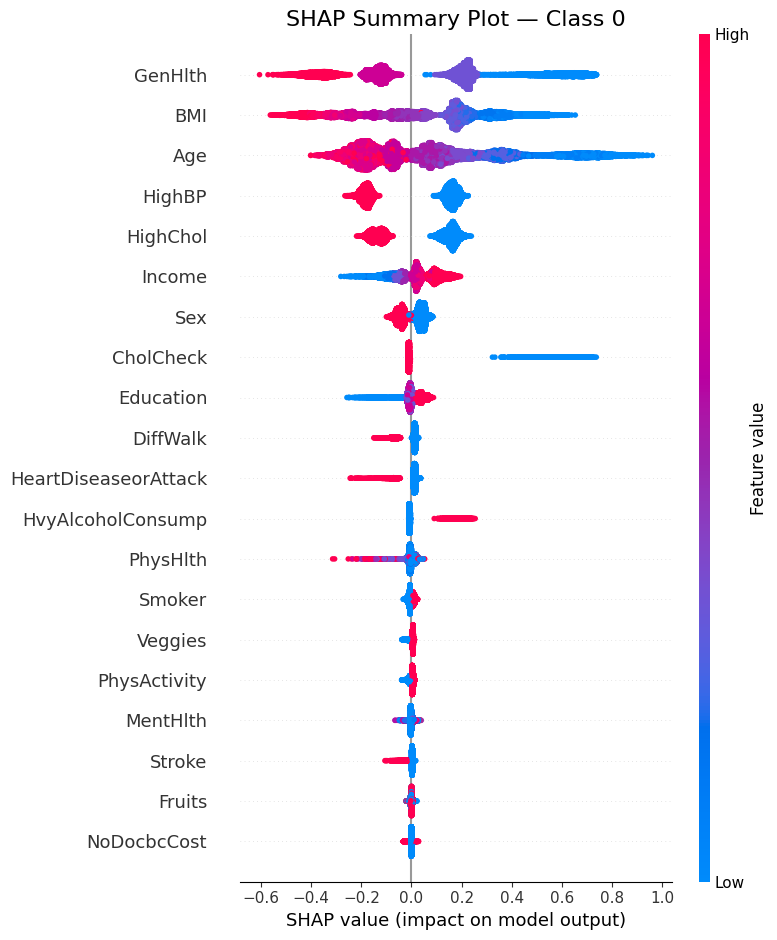


=== Class 1 SHAP Summary Plot (signed) ===


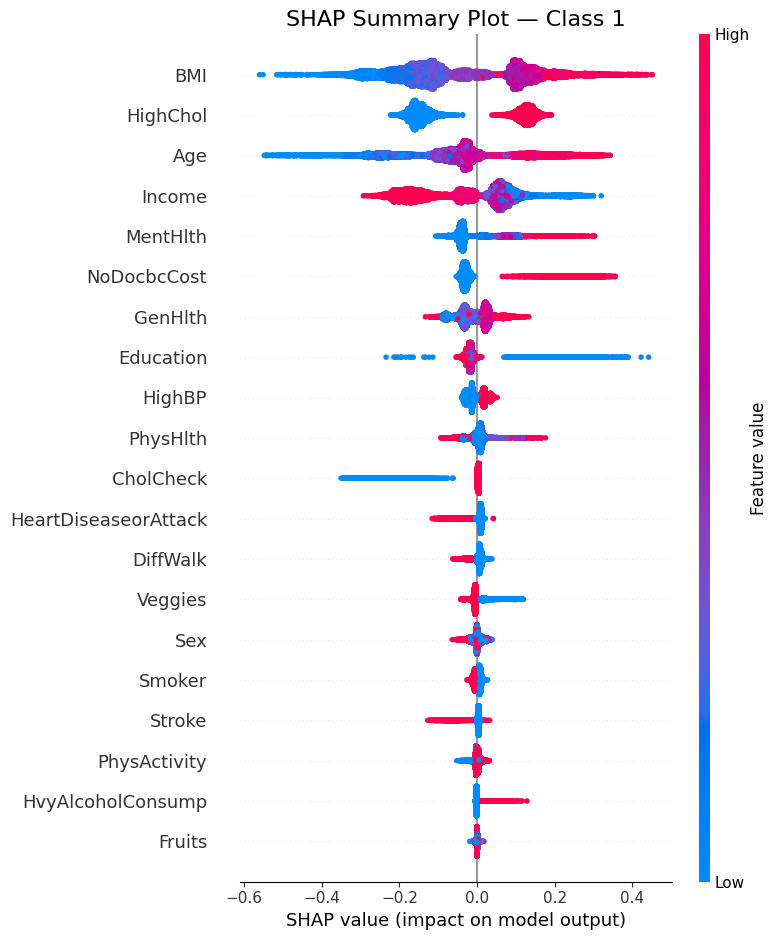


=== Class 2 SHAP Summary Plot (signed) ===


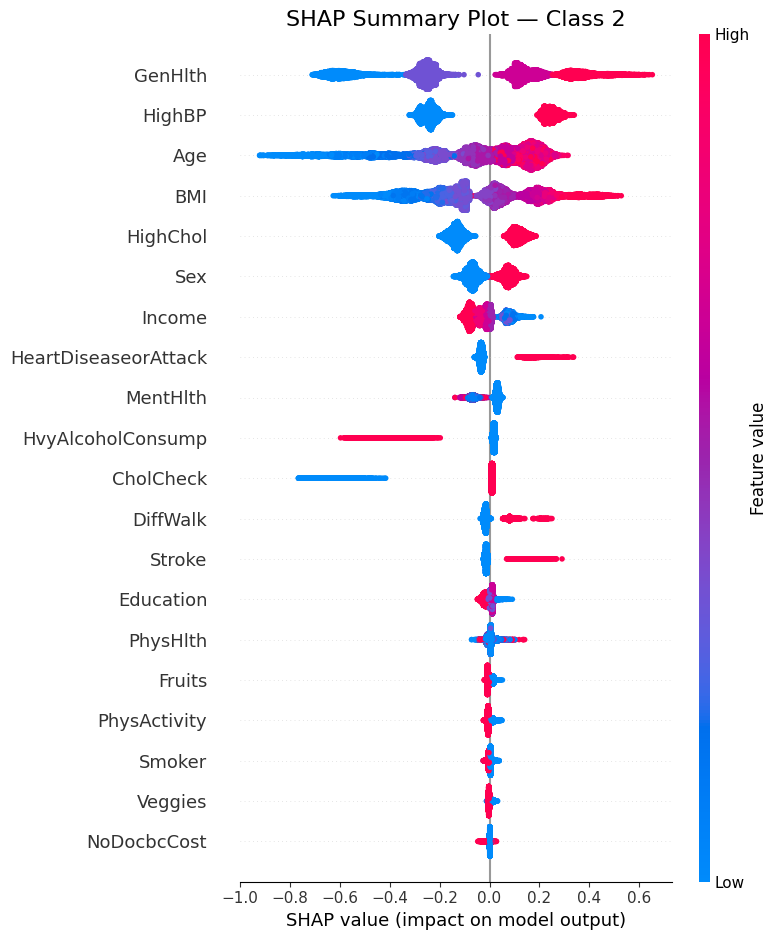

In [62]:
import matplotlib.pyplot as plt

for class_idx in range(len(shap_values)):   # 0, 1, 2
    print(f"\n=== Class {class_idx} SHAP Summary Plot (signed) ===")
    
    shap.summary_plot(
        shap_values[class_idx], 
        X_test,
        feature_names=X_test.columns,
        plot_type="dot",
        show=False   # <-- IMPORTANT: prevent immediate display
    )
    
    plt.title(f"SHAP Summary Plot — Class {class_idx}", fontsize=16)
    plt.tight_layout()
    plt.show()
